# Inpainting missing data

Missing data in an image can be an issue, especially when one wants to perform Fourier analysis.
This tutorial explains how to fill-up missing pixels with values which looks "realistic" and introduce as little perturbation as possible for subsequent analysis.
The user should keep the mask nearby and only consider the values of actual pixels and never the one inpainted.

This tutorial will use fully synthetic data to allow comparison between actual (syntetic) data with inpainted values.

The first part of the tutorial is about the generation of a challenging 2D diffraction image with realistic noise and to describe the metric used, then comes the actual tutorial on how to use the inpainting. Finally a benchmark is used based on the metric determined.

## Creation of the image

A realistic challenging image should contain:

* Bragg peak rings. We chose LaB6 as guinea-pig, with very sharp peaks, at the limit of the resolution of the detector
* Some amorphous content
* strong polarization effect
* Poissonian noise


One image will be generated but then multiple ones with different noise to discriminate the effect of the noise from other effects.

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyFAI
from pyFAI.gui import jupyter
import pyFAI.test.utilstest
from pyFAI.calibrant import CALIBRANT_FACTORY
import time
start_time = time.time()

In [3]:
detector = pyFAI.detector_factory("Pilatus2MCdTe")
mask = detector.mask.copy()
nomask = numpy.zeros_like(mask)
detector.mask=nomask
ai = pyFAI.AzimuthalIntegrator(detector=detector)
ai.setFit2D(200, 200, 200)
ai.wavelength = 3e-11
print(ai)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 3.000000e-11m
SampleDetDist= 2.000000e-01m	PONI= 3.440000e-02, 3.440000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 200.000mm	Center: x=200.000, y=200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


LaB6 Calibrant at wavelength 3e-11


<IPython.core.display.Javascript object>


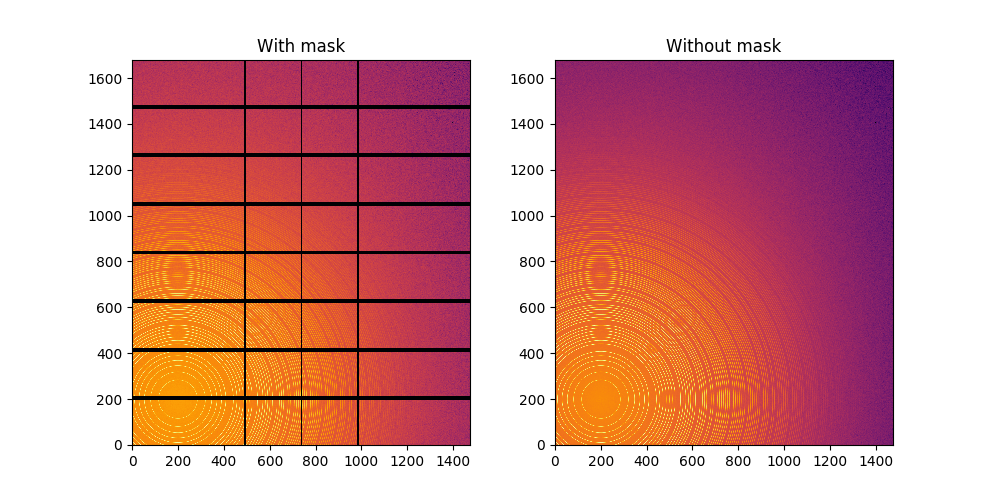

In [4]:
LaB6 = CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = ai.wavelength
print(LaB6)
r = ai.array_from_unit(unit="q_nm^-1")
decay_b = numpy.exp(-(r-50)**2/2000)
bragg = LaB6.fake_calibration_image(ai, Imax=1e4, W=1e-6) * ai.polarization(factor=1.0) * decay_b
decay_a = numpy.exp(-r/100)
amorphous = 1000*ai.polarization(factor=1.0)*ai.solidAngleArray() * decay_a
img_nomask = bragg + amorphous
#Not the same noise function for all images two images
img_nomask = numpy.random.poisson(img_nomask)
img_nomask2 = numpy.random.poisson(img_nomask)
img = numpy.random.poisson(img_nomask)
img[numpy.where(mask)] = -1
fig,ax = subplots(1,2, figsize=(10,5))
jupyter.display(img=img, label="With mask", ax=ax[0])
jupyter.display(img=img_nomask, label="Without mask", ax=ax[1])

Note the aliassing effect on the displayed images.

We will measure now the effect after 1D intergeration. We do not correct for polarization on purpose to highlight the defect one wishes to whipe out. We use a R-factor to describe the quality of the 1D-integrated signal. 

<IPython.core.display.Javascript object>


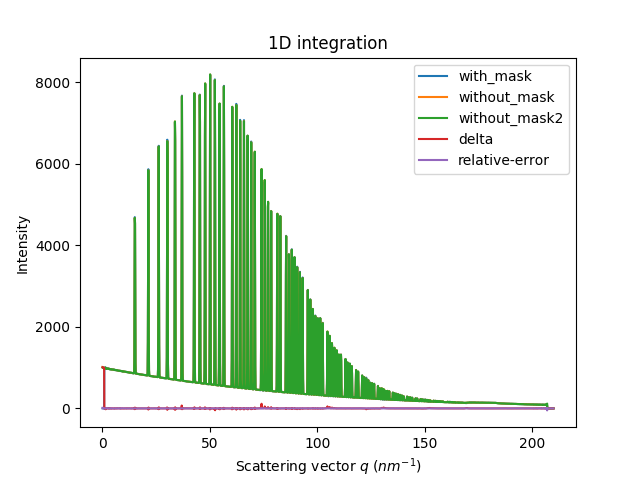

Between masked and non masked image R= 5.67458695153
Between two different non-masked images R'= 0.551586139858


In [5]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo2 = ai.integrate1d(img_nomask2, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wm = ai.integrate1d(img, 2000, unit="q_nm^-1", method="splitpixel", mask=mask, radial_range=(0,210))
ax = jupyter.plot1d(wm , label="with_mask")
ax.plot(*wo, label="without_mask")
ax.plot(*wo2, label="without_mask2")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.plot(wo.radial, wo.intensity-wo2.intensity, label="relative-error")
ax.legend()
print("Between masked and non masked image R= %s"%pyFAI.test.utilstest.Rwp(wm,wo))
print("Between two different non-masked images R'= %s"%pyFAI.test.utilstest.Rwp(wo2,wo))

<IPython.core.display.Javascript object>


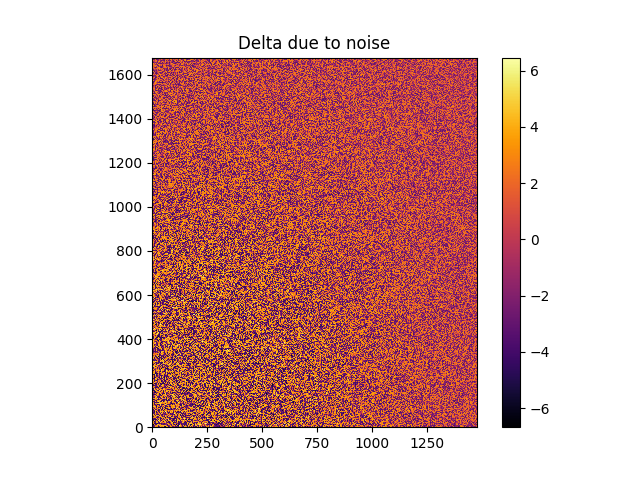

In [6]:
# Effect of the noise on the delta image
fig, ax = subplots()
jupyter.display(img=img_nomask-img_nomask2, label="Delta due to noise", ax=ax)
ax.figure.colorbar(ax.images[0])

## Inpainting

This part describes how to paint the missing pixels for having a "natural-looking image". The delta image contains the difference with the original image

<IPython.core.display.Javascript object>


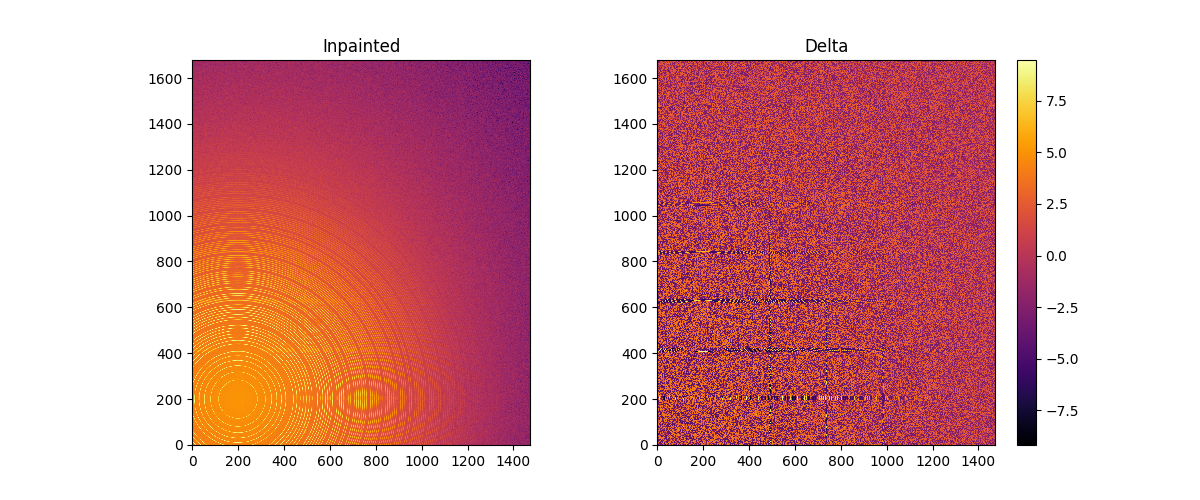

In [7]:
#Inpainting:
inpainted = ai.inpainting(img, mask=mask, poissonian=True)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


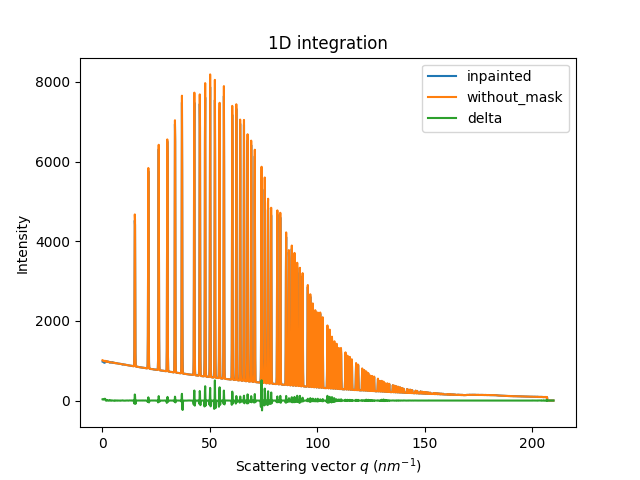

R= 1.29702309331


In [8]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.test.utilstest.Rwp(wm,wo))

One can see by zooming in that the main effect on inpainting is a broadening of the signal in the inpainted region. This could (partially) be adressed by increasing the number of radial bins used in the inpainting.

## Benchmarking and optimization of the parameters

The parameter set depends on the detector, the experiment geometry and the type of signal on the detector. Finer detail require finer slicing.

In [9]:
#Basic benchmarking of execution time for default options:
% timeit inpainted = ai.inpainting(img, mask=mask)

1 loop, best of 3: 1.02 s per loop


In [10]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
for j in ("csr", "csr_nosplit"):
    for k in (512,1024,2048, 4096):
        ai.reset()
        for i in range(10):
            inpainted = ai.inpainting(img, mask=mask, poissonian=True, method=j, npt_rad=k, grow_mask=i)
            wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
            print("method: %s npt_rad=%i grow=%i; R= %s"%(j, k, i,pyFAI.test.utilstest.Rwp(wm,wo)))

method: csr npt_rad=512 grow=0; R= 3.16531900952
method: csr npt_rad=512 grow=1; R= 2.90661626647
method: csr npt_rad=512 grow=2; R= 2.71016236054
method: csr npt_rad=512 grow=3; R= 2.65757278769
method: csr npt_rad=512 grow=4; R= 2.621385871
method: csr npt_rad=512 grow=5; R= 2.5765002
method: csr npt_rad=512 grow=6; R= 2.54687468822
method: csr npt_rad=512 grow=7; R= 2.55089840858
method: csr npt_rad=512 grow=8; R= 2.53960742393
method: csr npt_rad=512 grow=9; R= 2.52746701013
method: csr npt_rad=1024 grow=0; R= 1.68892942202
method: csr npt_rad=1024 grow=1; R= 1.3215767039
method: csr npt_rad=1024 grow=2; R= 1.31756471743
method: csr npt_rad=1024 grow=3; R= 1.29758060164
method: csr npt_rad=1024 grow=4; R= 1.27712135949
method: csr npt_rad=1024 grow=5; R= 1.27732592326
method: csr npt_rad=1024 grow=6; R= 1.27403507206
method: csr npt_rad=1024 grow=7; R= 1.27237445994
method: csr npt_rad=1024 grow=8; R= 1.26810932789
method: csr npt_rad=1024 grow=9; R= 1.26648384927
method: csr npt_r

method: csr_nosplit npt_rad=512 grow=0; R= 3.87124022511
method: csr_nosplit npt_rad=512 grow=1; R= 2.9614063668
method: csr_nosplit npt_rad=512 grow=2; R= 2.68647273485
method: csr_nosplit npt_rad=512 grow=3; R= 2.61792644347
method: csr_nosplit npt_rad=512 grow=4; R= 2.58722653728
method: csr_nosplit npt_rad=512 grow=5; R= 2.61955957042
method: csr_nosplit npt_rad=512 grow=6; R= 2.58497055129
method: csr_nosplit npt_rad=512 grow=7; R= 2.54398329584
method: csr_nosplit npt_rad=512 grow=8; R= 2.52637346143
method: csr_nosplit npt_rad=512 grow=9; R= 2.52700057491


method: csr_nosplit npt_rad=1024 grow=0; R= 2.75074893814
method: csr_nosplit npt_rad=1024 grow=1; R= 1.45111485533
method: csr_nosplit npt_rad=1024 grow=2; R= 1.32496097103
method: csr_nosplit npt_rad=1024 grow=3; R= 1.28550501203
method: csr_nosplit npt_rad=1024 grow=4; R= 1.28215997441
method: csr_nosplit npt_rad=1024 grow=5; R= 1.30008754598
method: csr_nosplit npt_rad=1024 grow=6; R= 1.1747101915
method: csr_nosplit npt_rad=1024 grow=7; R= 1.14717079018
method: csr_nosplit npt_rad=1024 grow=8; R= 1.16172624826
method: csr_nosplit npt_rad=1024 grow=9; R= 1.1729699441


method: csr_nosplit npt_rad=2048 grow=0; R= 2.81974043368
method: csr_nosplit npt_rad=2048 grow=1; R= 1.2433519637
method: csr_nosplit npt_rad=2048 grow=2; R= 1.14905528859
method: csr_nosplit npt_rad=2048 grow=3; R= 1.05974772031
method: csr_nosplit npt_rad=2048 grow=4; R= 1.00621979396
method: csr_nosplit npt_rad=2048 grow=5; R= 0.922906352549
method: csr_nosplit npt_rad=2048 grow=6; R= 0.85485063302
method: csr_nosplit npt_rad=2048 grow=7; R= 0.791849588863
method: csr_nosplit npt_rad=2048 grow=8; R= 0.819170873643
method: csr_nosplit npt_rad=2048 grow=9; R= 0.786321177089


method: csr_nosplit npt_rad=4096 grow=0; R= 2.69843706715
method: csr_nosplit npt_rad=4096 grow=1; R= 1.22463837801
method: csr_nosplit npt_rad=4096 grow=2; R= 1.19804499986
method: csr_nosplit npt_rad=4096 grow=3; R= 1.19065362756
method: csr_nosplit npt_rad=4096 grow=4; R= 1.14662057456
method: csr_nosplit npt_rad=4096 grow=5; R= 1.14287122414
method: csr_nosplit npt_rad=4096 grow=6; R= 1.07897198073
method: csr_nosplit npt_rad=4096 grow=7; R= 1.05662545905
method: csr_nosplit npt_rad=4096 grow=8; R= 1.01166262611
method: csr_nosplit npt_rad=4096 grow=9; R= 0.981926246571


CPU times: user 3.95 s, sys: 756 ms, total: 4.7 s
Wall time: 1.56 s


<IPython.core.display.Javascript object>


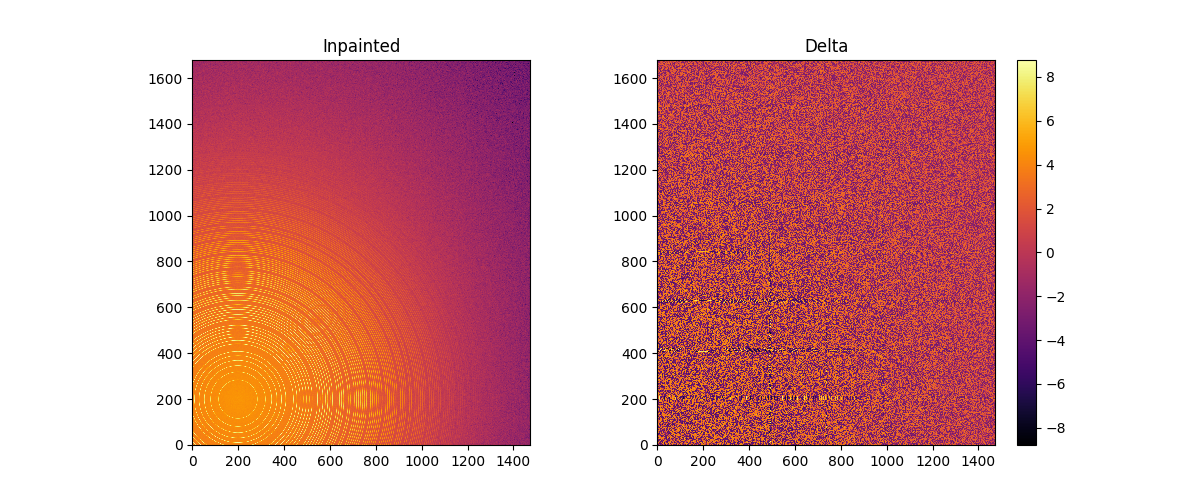

In [11]:
#Inpainting, best solution found:
ai.reset()
%time inpainted = ai.inpainting(img, mask=mask, poissonian=True, method="csr", npt_rad=4096, grow_mask=5)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


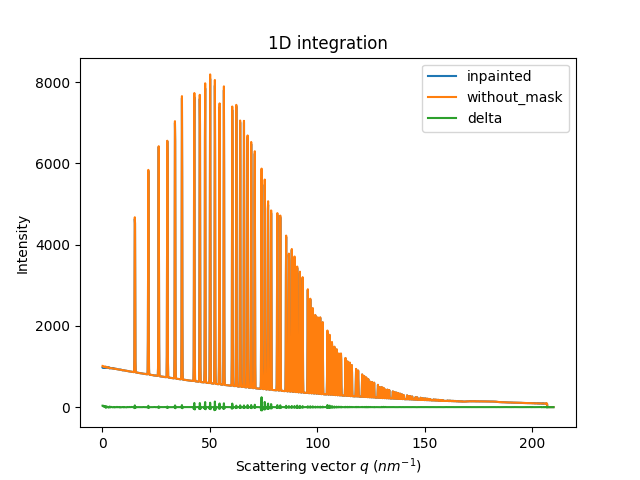

R= 0.422305155922


In [12]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.test.utilstest.Rwp(wm,wo))

## Conclusion

Inpainting is one of the only solution to fill up the gaps in detector when Fourier analysis is needed. 
This tutorial explains basically how this is possible using the pyFAI library and how to optimize the parameter set for inpainting. The result may greatly vary with detector position and tilt and the kind of signal (amorphous or more spotty).

In [13]:
print("Execution time: %.3fs"%(time.time()-start_time))

Execution time: 105.600s
